In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/Users/anastasiakurakova/Desktop/Data/stroke/stroke.csv')
data.head()
data = data.dropna()

In [3]:
data.shape

(4909, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.6+ KB


In [7]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train.to_csv("/Users/anastasiakurakova/Desktop/Data/stroke/stroke_train.csv", encoding='utf-8', index=False)
X_test.to_csv("/Users/anastasiakurakova/Desktop/Data/stroke_test.csv", encoding='utf-8', index=False)

In [8]:
data = X_train
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3565,68302,Female,40.0,0,0,Yes,Private,Urban,65.77,31.2,never smoked,0
898,62716,Female,59.0,0,0,Yes,Self-employed,Urban,81.64,32.8,Unknown,0
2707,46498,Female,57.0,0,0,Yes,Private,Urban,217.40,36.6,never smoked,0
4198,4148,Male,81.0,0,0,Yes,Self-employed,Urban,71.18,23.9,formerly smoked,0
2746,35315,Male,65.0,0,0,Yes,Self-employed,Urban,95.88,28.5,never smoked,0


In [15]:
# Using train and test data.
data = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/stroke/stroke_train.csv")
X_test = pd.read_csv("/Users/anastasiakurakova/Desktop/Data/stroke/stroke_test.csv")

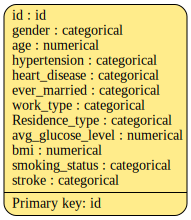

In [16]:
# Import SDV metadata package to use in evaluation
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)
metadata.visualize()

In [19]:
%%time
from sdv.single_table import TVAESynthesizer
model = TVAESynthesizer(metadata, epochs=1000)
model.fit(data)

CPU times: user 1min 2s, sys: 37.7 s, total: 1min 39s
Wall time: 1min 24s


###
Plotting Loss Values

In [20]:
import plotly.express as px
loss_values = model.get_loss_values()
loss_values_reformatted = pd.melt(
    loss_values,
    id_vars=['Epoch'],
    var_name='Loss Type'
)

fig = px.line(loss_values_reformatted, x="Epoch", y="value", color="Loss Type", title='Epoch vs. Loss')
fig.show()

In [21]:
synthetic_data = model.sample(len(data))
synthetic_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Female,6.83,0,0,No,children,Rural,79.74,17.9,never smoked,0
1,1,Male,53.19,1,0,Yes,Private,Urban,59.89,32.9,never smoked,0
2,2,Male,57.71,0,0,Yes,Private,Rural,103.16,31.1,never smoked,0
3,3,Male,23.55,0,0,Yes,Private,Rural,108.61,25.2,Unknown,0
4,4,Female,74.87,0,0,Yes,Self-employed,Rural,97.85,18.1,never smoked,0


In [24]:
#synthetic_data.to_csv('/Users/anastasiakurakova/Desktop/Data/Synthetic Data/stroke_TSTR_TVAE.csv', index=False)

In [29]:
# Find common duplicate rows between df1 and df2
common_duplicates = pd.merge(X_test, synthetic_data, how='inner')
new = common_duplicates.drop_duplicates()
# Print the common duplicate rows
print("Common Duplicate Rows:")
print(common_duplicates)
print(new)

Common Duplicate Rows:
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []
Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []


### Data Evaluation Using SDV Library

In [24]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

diagnostic = run_diagnostic(
    real_data=X_test,
    synthetic_data=synthetic_data,
    metadata=metadata
)
quality_report = evaluate_quality(
    X_test,
    synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 481.22it/s]

Overall Score: 99.94%

Properties:
- Data Validity: 99.87%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:00<00:00, 79.09it/s] 

Overall Score: 89.85%

Properties:
- Column Shapes: 93.56%
- Column Pair Trends: 86.14%


In [30]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,gender,TVComplement,0.958854
1,age,KSComplement,0.955713
2,hypertension,TVComplement,0.970483
3,heart_disease,TVComplement,0.946793
4,ever_married,TVComplement,0.969786
5,work_type,TVComplement,0.829752
6,Residence_type,TVComplement,0.997585
7,avg_glucose_level,KSComplement,0.860549
8,bmi,KSComplement,0.886747
9,smoking_status,TVComplement,0.958570


In [26]:
len(X_test)

982

### Calculate Range Coverage and KSComplement for Numerical Variables

In [32]:
from sdmetrics.single_column import RangeCoverage, KSComplement
for i in ['bmi','avg_glucose_level']:
  range_cov = RangeCoverage.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  ks = KSComplement.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  print(f"Range coverage for {i} is: {range_cov}")
  print(f"KSComplement for {i} is: {ks}")

Range coverage for bmi is: 0.5887743413516611
KSComplement for bmi is: 0.8867472928812332
Range coverage for avg_glucose_level is: 1
KSComplement for avg_glucose_level is: 0.8605494780767333


### Calculate Category Coverage and TVComplement for Categorical Variables

In [33]:

from sdmetrics.single_column import CategoryCoverage, TVComplement
for i in ['work_type','smoking_status']:
  cat_cov = CategoryCoverage.compute(
    real_data=X_test[i],
    synthetic_data=synthetic_data[i]
  )
  tv = TVComplement.compute(
      real_data=X_test[i],
      synthetic_data=synthetic_data[i]
  )
  print(f"Category coverage for {i} is: {cat_cov}")
  print(f"TVComplement for {i} is: {tv}")

Category coverage for work_type is: 1.0
TVComplement for work_type is: 0.8297516747858188
Category coverage for smoking_status is: 1.0
TVComplement for smoking_status is: 0.9585695044542535



### Evaluation using Table Evaluator

(982, 12) (3927, 12)


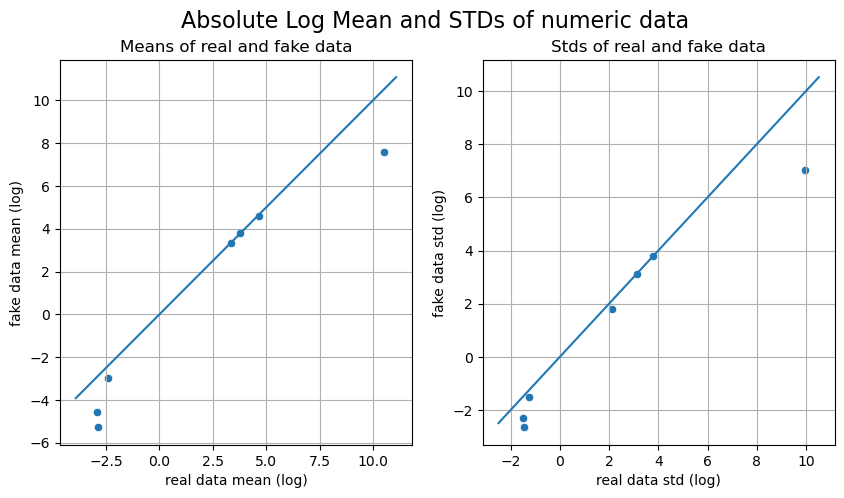

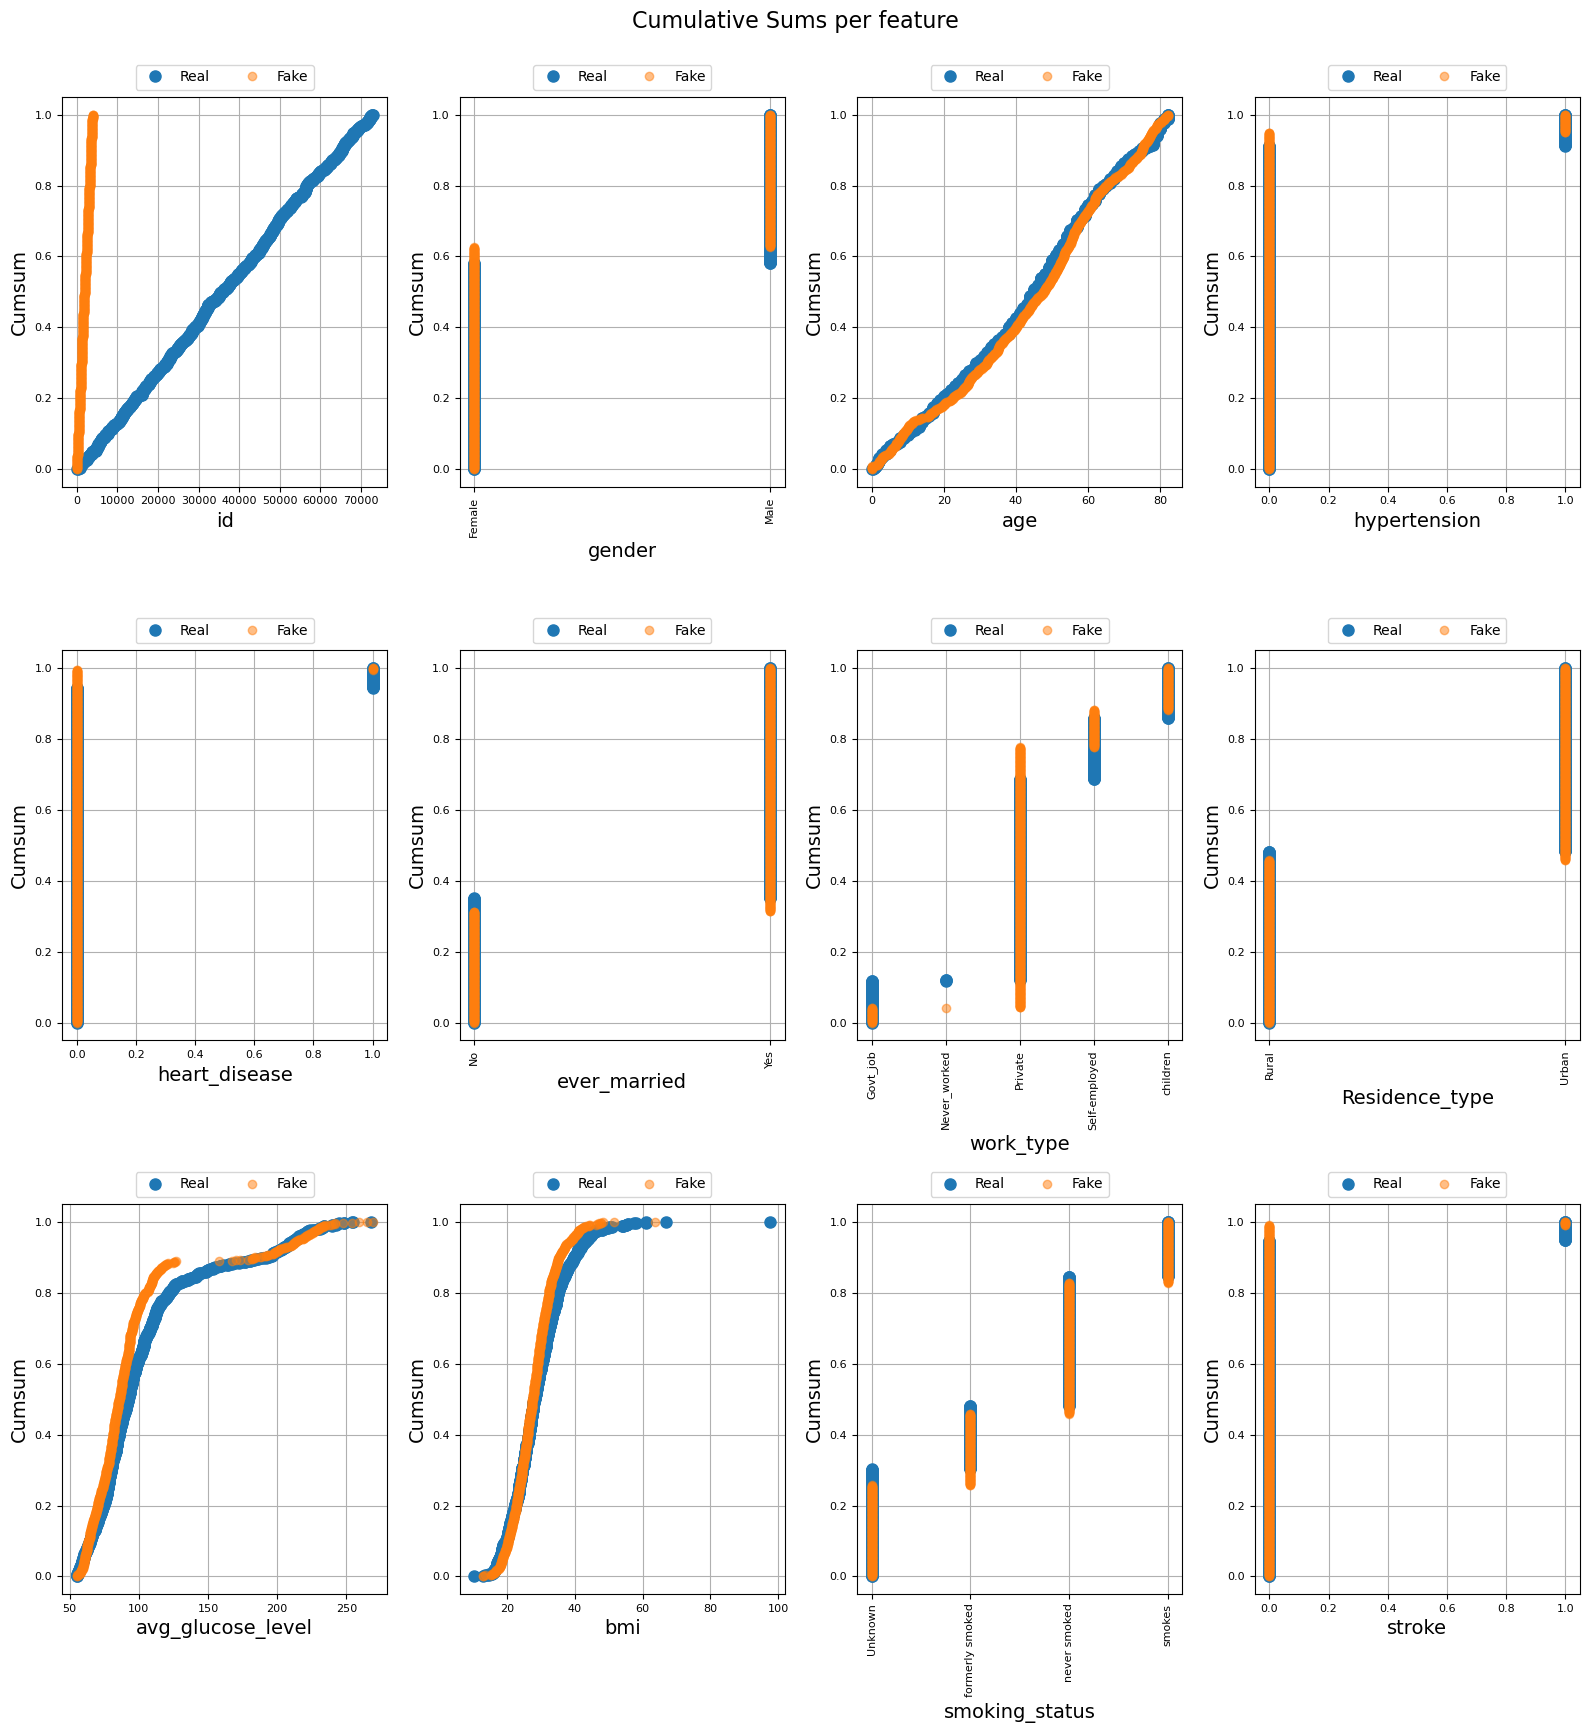

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/Users/anastasiakurakova/min

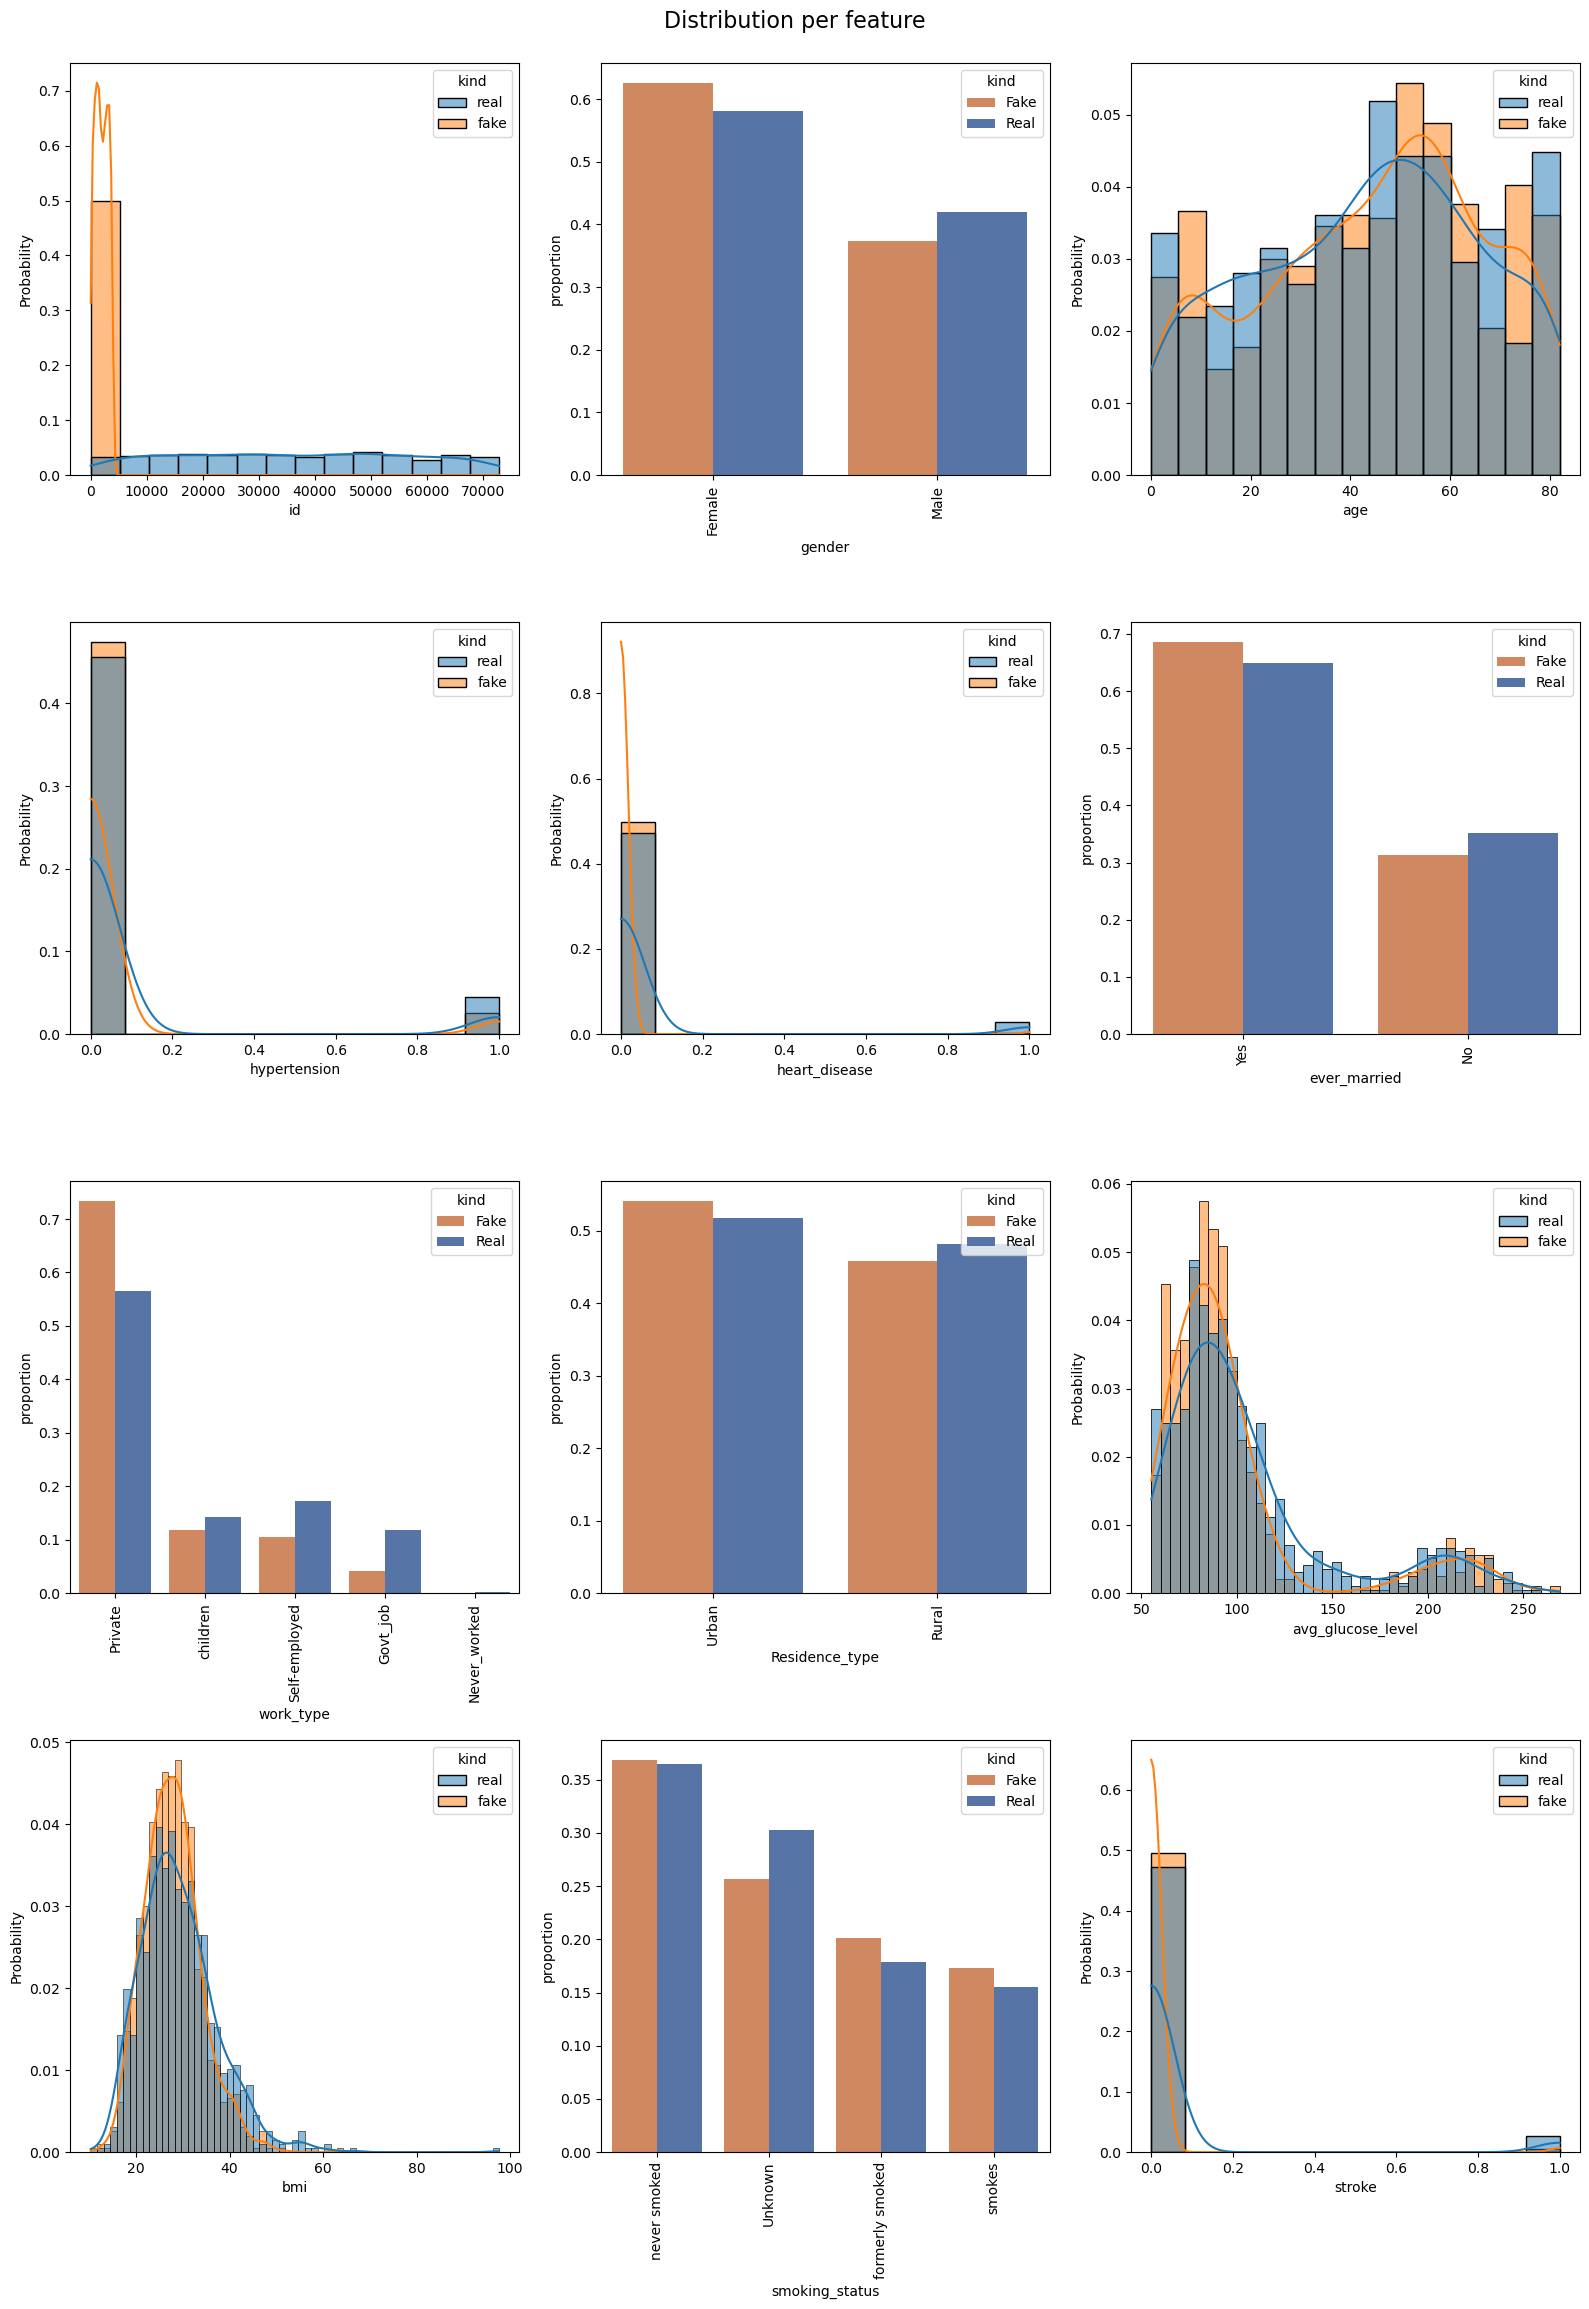

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython

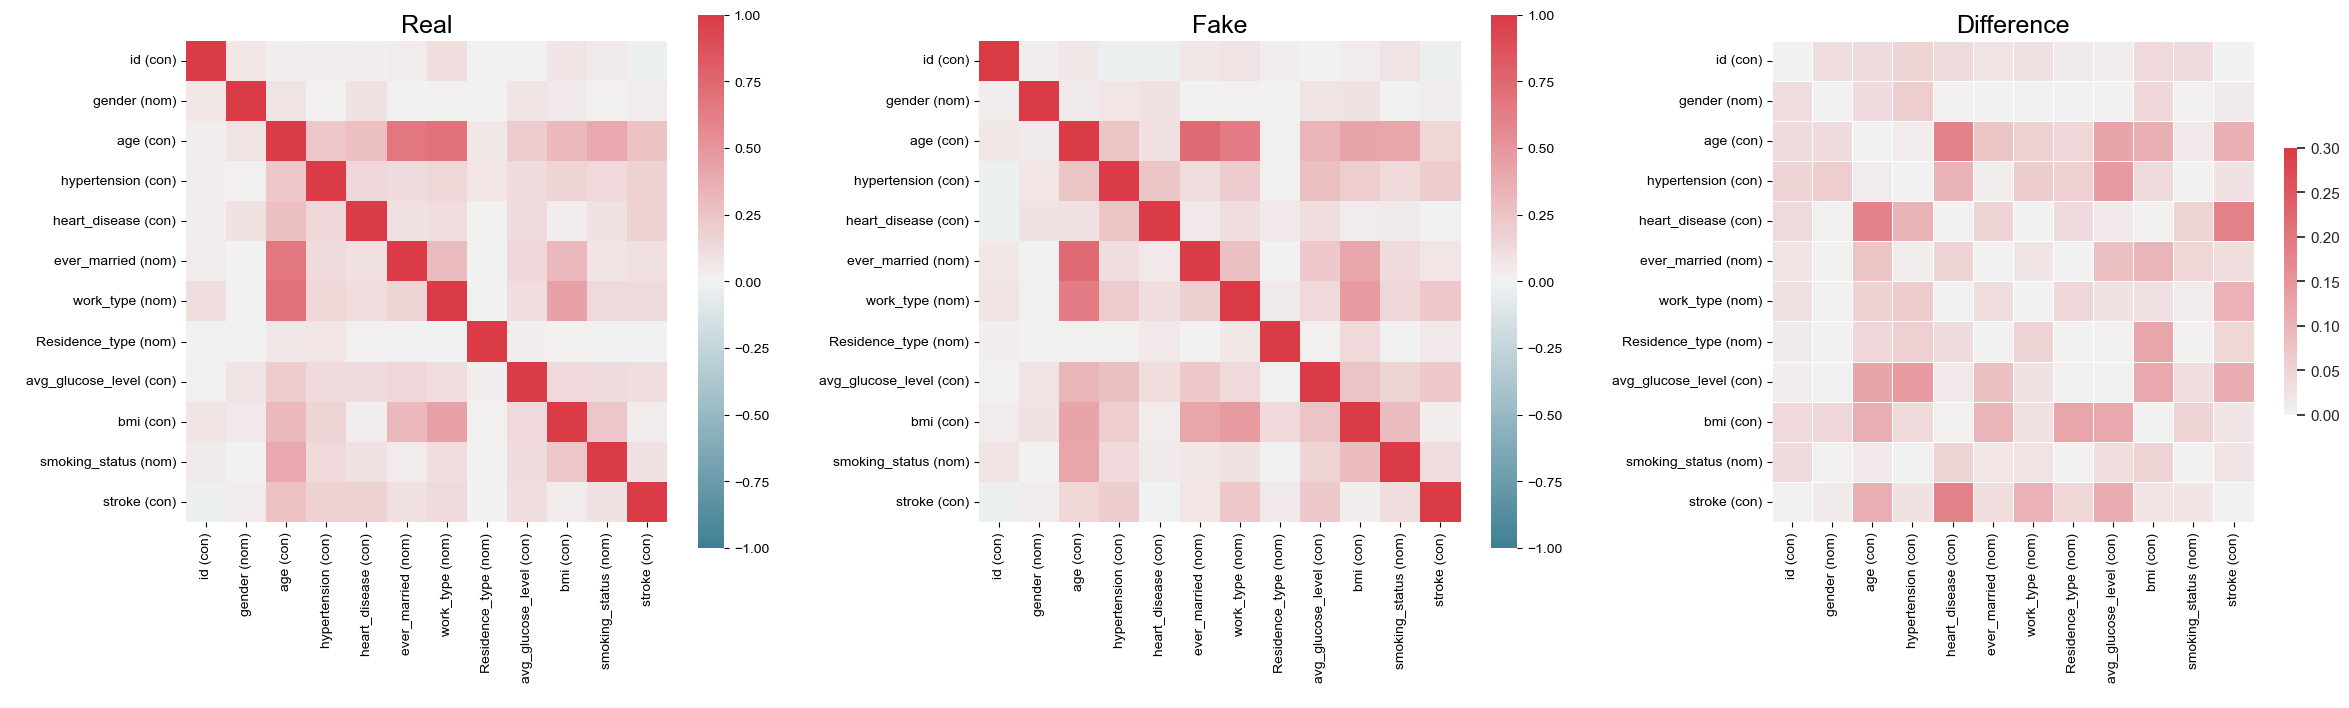

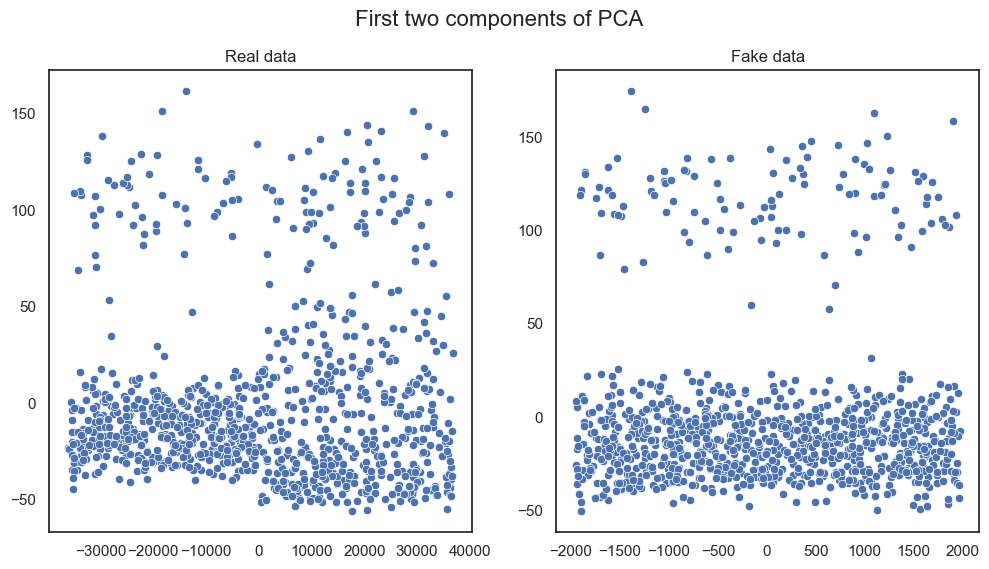

In [35]:
from table_evaluator import TableEvaluator
print(X_test.shape,synthetic_data.shape)
table_evaluator = TableEvaluator(X_test,synthetic_data)
table_evaluator.visual_evaluation()

In [36]:
table_evaluator.evaluate(target_col='smoking_status')

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:705: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython/nominal.py:704: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/dython


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.3452   0.3959              0.2274
DecisionTreeClassifier_real   0.4213   0.3350              0.2012
LogisticRegression_fake       0.4112   0.4365              0.5451
LogisticRegression_real       0.4772   0.4061              0.4981
MLPClassifier_fake            0.1878   0.3096              0.0207
MLPClassifier_real            0.1066   0.3655              0.0000
RandomForestClassifier_fake   0.3959   0.4315              0.2274
RandomForestClassifier_real   0.3959   0.3706              0.2160

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.0697
nearest neighbor std                     0.4924

Miscellaneous results:
                                  Result
Column Cor

#### Finding Wassetstein Distance and KL Divergence (Testing/Training vs Testing/Synthetic)

In [39]:
from scipy.stats import wasserstein_distance
wasserstein_distances = {}
for column in X_test.columns[8:10]:
    wasserstein_dist = wasserstein_distance(X_test[column], synthetic_data[column])
    wasserstein_distances[column] = wasserstein_dist
# Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'For Testing data vs Synthetic Data {column}: {distance}')

For Testing data vs Synthetic Data avg_glucose_level: 6.821012679465418
For Testing data vs Synthetic Data bmi: 1.6588073481568144


In [40]:
wasserstein_distances = {}
for column in X_test.columns[8:10]:
    wasserstein_dist = wasserstein_distance(X_test[column], data[column])
    wasserstein_distances[column] = wasserstein_dist
# Print Wasserstein distances for each feature
for column, distance in wasserstein_distances.items():
    print(f'For Testing data vs Training Data {column}: {distance}')

For Testing data vs Training Data avg_glucose_level: 0.9210892240621485
For Testing data vs Training Data bmi: 0.4357661227794204


In [41]:
# Calculate KL Divergence for each feature
from scipy.stats import entropy
kl_divergences = {}
for column in X_test.columns[8:10]:
    kl_divergence = entropy(X_test[column], synthetic_data[column][:len(X_test)])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f'For Testing data vs Synthetic Data {column}: {divergence}')

For Testing data vs Synthetic Data avg_glucose_level: 0.14760967696589772
For Testing data vs Synthetic Data bmi: 0.06198169857836658


In [42]:
# Calculate KL Divergence for each feature
from scipy.stats import entropy
kl_divergences = {}
for column in X_test.columns[8:10]:
    kl_divergence = entropy(X_test[column], data[column][:len(X_test)])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f'For Testing data vs Training Data {column}: {divergence}')

For Testing data vs Training Data avg_glucose_level: 0.14953756572088872
For Testing data vs Training Data bmi: 0.07350233765670086


MSE and R-Squared

In [28]:
# Check for MSE and r2
from sklearn.metrics import mean_squared_error, r2_score
# Calculate MSE between testing_data and real_data
mse_real = mean_squared_error(X_test['bmi'], data[:len(X_test)]['bmi'])
print("MSE between Testing Data and Real Data:", mse_real)

# Calculate MSE between testing_data and synthetic_data
mse_synthetic = mean_squared_error(X_test['bmi'], synthetic_data[:len(X_test)]['bmi'])
print("MSE between Testing Data and Synthetic Data:", mse_synthetic)

# Calculate R-squared (R2) score
r2 = r2_score(X_test['bmi'], data[:len(X_test)]['bmi'])
print("R-squared Score (between Testing Data and Real Data):", r2)

r2 = r2_score(X_test['bmi'], synthetic_data[:len(X_test)]['bmi'])
print("R-squared Score (between Testing Data and Synthetic Data):", r2)

MSE between Testing Data and Real Data: 128.20159877800407
MSE between Testing Data and Synthetic Data: 108.65396130346232
R-squared Score (between Testing Data and Real Data): -0.8731813259365859
R-squared Score (between Testing Data and Synthetic Data): -0.5875665611246814
